# 라이브러리 설치

In [116]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import gensim
import gensim.corpora as corpora
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import pyLDAvis 
import pyLDAvis.gensim as gensimvis 

from wordcloud import WordCloud, STOPWORDS 
from scipy.sparse import hstack
from collections import Counter
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀 모델
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLTK 불용어 가져오기
import nltk
# NLTK 초기화
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 경고 출력 제외
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트를 설정하여 시각화에 한글이 깨지지 않도록 설정
plt.rcParams['font.family'] = 'AppleGothic'

[nltk_data] Downloading package punkt to /Users/iyuseon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iyuseon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/iyuseon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/iyuseon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 데이터 불러오기

In [117]:
df = pd.read_csv("/Users/iyuseon/Downloads/archive (2)/chatgpt_sentiment.csv")

# 데이터 정의

소셜 미디어(트위터)에서 ChatGPT 관련 게시글을 분석한 데이터입니다.  
각 행은 하나의 게시글을 나타내며, 감성 분석 결과 및 사용자 정보가 포함되어 있습니다.  
데이터는 **12개의 열**로 구성되어 있습니다.  

     
< Text >  원본 게시글 내용  
< negative >  게시글이 부정적(negative)일 확률 (0~1)  
< neutral >  게시글이 중립적(neutral)일 확률 (0~1)  
< positive >  게시글이 긍정적(positive)일 확률 (0~1)  
< predicted_label >  모델이 예측한 게시글의 감성(Sentiment) 라벨 (negative, neutral, positive)  
< date >  게시글이 작성된 날짜 및 시간 (UTC 기준)  
< likes >  게시글이 받은 좋아요(Like) 수  
< location >  게시글을 작성한 사용자의 위치 정보 (알려지지 않은 경우 Unknown)  
< followers >  게시글 작성자의 팔로워 수  
< following >  게시글 작성자가 팔로우하는 사람 수  
< retweets >  게시글이 리트윗된 횟수  
< replies >  게시글에 달린 댓글(Reply) 수            

# 기본 통계 확인

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975450 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             975027 non-null  object 
 1   negative         975450 non-null  float64
 2   neutral          975450 non-null  float64
 3   positive         975450 non-null  float64
 4   predicted_label  975450 non-null  object 
 5   date             975450 non-null  object 
 6   likes            975450 non-null  int64  
 7   location         705265 non-null  object 
 8   followers        975450 non-null  int64  
 9   following        975450 non-null  int64  
 10  retweets         975450 non-null  int64  
 11  replies          975450 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 89.3+ MB


In [119]:
df.shape

(975450, 12)

In [120]:
df.describe()

,negative,neutral,positive,likes,followers,following,retweets,replies
count,975450.000000,975450.000000,975450.000000,975450.000000,9.754500e+05,9.754500e+05,975450.000000,975450.000000
mean,0.224028,0.437321,0.338650,11.961189,3.231735e+04,1.573738e+03,1.765541,1.114315
std,0.349075,0.374737,0.377395,355.771275,7.281230e+05,9.618419e+03,57.776420,36.731214
min,0.001543,0.005018,0.003674,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.006844,0.052123,0.018617,0.000000,8.600000e+01,1.480000e+02,0.000000,0.000000
50%,0.024687,0.355728,0.116684,1.000000,4.390000e+02,4.600000e+02,0.000000,0.000000
75%,0.254022,0.846569,0.746904,2.000000,2.041000e+03,1.214000e+03,0.000000,1.000000
max,0.986359,0.993227,0.990427,111653.000000,1.287402e+08,1.526451e+06,13072.000000,19942.000000


In [121]:
df.isnull().sum()

Text                  423
negative                0
neutral                 0
positive                0
predicted_label         0
date                    0
likes                   0
location           270185
followers               0
following               0
retweets                0
replies                 0
dtype: int64

> Text 열에 423개의 결측치, location 열에 270,185개의 결측치 있음을 확인.

# 전처리

In [122]:
# date를 년/월/일로 분리
df['date'] = pd.to_datetime(df['date'])

In [123]:
# Text칼럼의 결측값은 420개로 제거하기로 결정
# Text 컬럼의 결측값 제거
df = df[df['Text'].notnull()]

In [124]:
# location 칼럼의 결측치는 250,000개로 제거하기에는 큰 결측치라고 판단하여 대체하기로 결정
# location 컬럼에서 결측값을 "Unknown"으로 대체
df['location'] = df['location'].fillna("Unknown")

In [125]:
# 결측치가 잘 처리된 것을 확인할 수 있음
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975027 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   Text             975027 non-null  object             
 1   negative         975027 non-null  float64            
 2   neutral          975027 non-null  float64            
 3   positive         975027 non-null  float64            
 4   predicted_label  975027 non-null  object             
 5   date             975027 non-null  datetime64[ns, UTC]
 6   likes            975027 non-null  int64              
 7   location         975027 non-null  object             
 8   followers        975027 non-null  int64              
 9   following        975027 non-null  int64              
 10  retweets         975027 non-null  int64              
 11  replies          975027 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(5), object(3)
memo

# 필터링

In [126]:
df = df[(df['positive'] > 0.8) | (df['negative'] > 0.8)]

In [127]:
df = df[(df['likes'] > 10) | (df['retweets'] > 5) | (df['replies'] > 3)]

> 데이터 크기가 너무 커서 분석에 어려움이 있기 때문에 필터링 실행   
긍정적/부정적 반응이 명확한 텍스트를 고르기 위해 각각의 비율이 0.8 이상인 데이터만 추출  
[ likes, retweets, replies ]는 최소한의 반응이 있다고 판단되는 기준을 임의로 설정하여 필터링  

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32076 entries, 22 to 975448
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Text             32076 non-null  object             
 1   negative         32076 non-null  float64            
 2   neutral          32076 non-null  float64            
 3   positive         32076 non-null  float64            
 4   predicted_label  32076 non-null  object             
 5   date             32076 non-null  datetime64[ns, UTC]
 6   likes            32076 non-null  int64              
 7   location         32076 non-null  object             
 8   followers        32076 non-null  int64              
 9   following        32076 non-null  int64              
 10  retweets         32076 non-null  int64              
 11  replies          32076 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(5), object(3)
memory usage: 3.2+

데이터의 크기가 줄어든 것을 확인함.  
 텍스트 분석에서 기본적인 머신러닝을 위한 3만개의 데이터는 적절하다 생각하여 이 데이터로 분석을 진행하기로 함. 

# 텍스트 분석 함수 정의 

< **불용어** > 문장의 의미를 크게 변화시키지 않는 불필요한 단어   
  
영어의 기본적인 불용어 리스트를 불용어로 설정하고, 트위터에서 자주 쓰이는 분석에 의미 없는 용어들과 해당 데이터 분석의 핵심단어인 chatgpt와 관련된 키워드들을 불용어 리스트에 추가하여 통합시킨다. 









In [129]:
# 기본 불용어
stop_words = set(stopwords.words('english'))

# 트윗 전용 추가 불용어
# tweet_stopwords = ['rt', 'via', 'amp', 'http', 'https', 'www', 'com', 'co', 'u', 'us',
#                    'like', 'follow', 'followers', 'retweet', 'tweet', 'tweets', 'reply', 'replies',
#                    'chatgpt', 'openai', 'open', 'chat', 'gpt', 'im', 'ive', 'cant', 'ai', 'get', 'use', 'ask', 'try', 'open']

# 통합된 불용어 리스트
stop_words.update(['rt', 'via', 'amp', 'http', 'https', 'www', 'com', 'co', 'u', 'us',
                   'like', 'follow', 'followers', 'retweet', 'tweet', 'tweets', 'reply', 'replies',
                   'chatgpt', 'openai', 'open', 'chat', 'gpt', 'im', 'ive', 'cant', 'ai', 'get', 'use', 'ask', 'try', 'open'])

print(stop_words)

{'only', "wasn't", 'my', 'weren', 'cant', 'myself', 'won', "should've", 'replies', 'has', 'theirs', 'doing', 'it', 'than', 'isn', 'having', "mightn't", 'u', 'so', 'should', 'against', 'hadn', 'why', 'am', 'if', 'which', 'is', "shouldn't", "you'll", 'like', 'such', 'amp', "needn't", 'again', 'and', 'just', 'his', 'll', "hadn't", 'no', 'a', 'before', 'aren', 'any', 'this', 'those', 'me', 'from', 'below', 'gpt', 'or', 'followers', 'same', 'mightn', 'open', 'we', "haven't", 'com', 'own', 'nor', 'y', 'couldn', 'had', 'follow', 'http', 'our', 'here', 'other', 'he', 'does', 'don', 'try', 'some', 'did', "won't", 'hasn', "wouldn't", 'then', 'yours', 'where', 'up', 'all', 'who', 'wasn', 'at', 'their', 'but', 'openai', 'chat', 'into', "that'll", 'over', 'of', 'whom', 'didn', 'during', 'each', 'not', 'more', 'her', 'being', 'mustn', 'reply', 'ai', 'an', 'will', 'until', 'ours', "couldn't", 'shouldn', 'while', 'how', 'its', 'm', 'with', 'yourself', 'doesn', 'now', 'that', 'ive', 'down', 'were', 'ww

In [130]:
# 변수 초기화
lemmatizer = WordNetLemmatizer()

# 텍스트 전처리 함수 정의
def preprocess_text(text_data, get_lemma=True, tags=(), stop_words=[]):
    # 소문자 변경
    text_data = text_data.lower()
    # URL 제거
    text_data = re.sub(r'((www\.\S+)|(https?://\S+))', r"", text_data)
    # HTML 태그 제거
    text_data = re.sub(r'<[^>]+>', r'', text_data)
    # 숫자 제거
    text_data = re.sub(r'[0-9]\S+', r'', text_data)
    # 문장부호 제거
    text_data = text_data.translate(str.maketrans("", "", string.punctuation))
    # 토큰화
    tokens = word_tokenize(text_data)
    # 불용어 제거
    tokens = [word for word in tokens if word not in stop_words]
    # 래마타이즈
    if get_lemma:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # 동사 형태로 lemmatize
        tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]  # 명사 형태로 lemmatize
    # POS 필터
    if tags:
        tokens = [word for word, pos in nltk.pos_tag(tokens) if pos.startswith(tags)]
    return " ".join(tokens)

# Sentence to Word 함수
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# 공백 제거 함수 정의
def remove_extra_spaces(text_data):
    # 단어별로 분리된 텍스트에서 각 단어의 앞뒤 공백을 제거하고 다시 결합
    return " ".join([word.strip() for word in text_data.split()])

# 품사 태그 설정
TAGS = ("JJ", "NN", "RB", "VB")

WordNetLEmmatizer : 표제어 추출을 수행  
< 표제어 추출 > 단어를 원형으로 변환하는 과정을 말한다.  
            ex) 달리는 중이다 -> 달리다. 낫다 -> 좋다  
  
**1. 텍스트 전처리 함수**
1) 일관성 유지를 위해 모든 문자를 소문자로 변환한다.  
2) URL 제거  
3) 숫자와 문장부호 제거   
4) 토큰화를 통해 문장을 단어 단위로 분할한다. 토큰화된 단어가 불용어인 경우 제거하는 과정을 포함한다.   
5) 동사 형태와 명사 형태로 표제어를 추출하도록 하고, 특정 품사만 유지하도록 설정한다. { 형용사(JJ), 명사(NN), 부사(RB), 동사(VB) }
  
**2. 문장을 단어 리스트로 추출하는 함수 정의**
  
**3. 여러개의 공백을 하나로 줄이고 불필요한 공백은 제거해주는 함수 정의**
  


In [131]:
try:
    df['cleaned_text'] = df.apply(
        lambda x: preprocess_text(str(x['Text']), get_lemma=True, tags=TAGS, stop_words=stop_words), axis=1
    )
    print("cleaned_text 컬럼이 생성되었습니다.")
except Exception as e:
    print(f"cleaned_text 생성 중 오류 발생: {e}")

# 전처리된 데이터 예시 출력
if 'cleaned_text' in df.columns:
    print(df[['cleaned_text']].head())
else:
    print("cleaned_text 컬럼이 생성되지 않았습니다.")

cleaned_text 컬럼이 생성되었습니다.
                                          cleaned_text
22                                     bbig get snitch
44   hour long conversation matrix math optimizatio...
85      great see many people person online talk learn
119  check chip respond fast give really indepth an...
144  nice list definitely watch octane x release ap...


In [132]:
# cleaned_text 컬럼 전처리
def preprocess_dataset(df, tags, stop_words):
    df['cleaned_text'] = df.apply(
        lambda x: preprocess_text(x['Text'], get_lemma=True, tags=tags, stop_words=stop_words), axis=1
    )
    return df

df의 'Text'칼럼을 가져와 전처리 함수를 적용시키고 표제어 추출, 특정 품사만 필터링 추출 및 불용어제거 과정을 행단위로 수행한 결과를 'cleaned_text' 칼럼에 생성시킨다.

In [133]:
# 전처리된 데이터 예시 출력
print(df[['cleaned_text']].head())

                                          cleaned_text
22                                     bbig get snitch
44   hour long conversation matrix math optimizatio...
85      great see many people person online talk learn
119  check chip respond fast give really indepth an...
144  nice list definitely watch octane x release ap...


In [134]:
df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies,cleaned_text
22,BBIG Just got ChatGPT OpenAI to snitch on its...,0.978697,0.013870,0.007433,negative,2023-02-10 23:57:31+00:00,22,Unknown,8417,1834,4,2,bbig get snitch
44,Had an hour long conversation with ChatGPT abo...,0.006905,0.062680,0.930414,positive,2023-02-10 23:55:26+00:00,831,Nintendo Jail,28671,4,20,25,hour long conversation matrix math optimizatio...
85,Great to see so many people in person and onli...,0.006372,0.010792,0.982836,positive,2023-02-10 23:52:18+00:00,22,"Adelaide, South Australia",472,719,4,1,great see many people person online talk learn
119,Check out CHIP. The AI responds fast and gives...,0.008253,0.076214,0.915533,positive,2023-02-10 23:49:14+00:00,10,Los Angeles,1802,4006,6,1,check chip respond fast give really indepth an...
144,"Nice list, is definitely one to watch! - Octan...",0.003453,0.027268,0.969279,positive,2023-02-10 23:46:40+00:00,12,Unknown,680,865,1,0,nice list definitely watch octane x release ap...


In [135]:
# 공백 제거
df['cleaned_text'] = df['cleaned_text'].apply(remove_extra_spaces)

# 결과 확인
print(df[['cleaned_text']].head())

                                          cleaned_text
22                                     bbig get snitch
44   hour long conversation matrix math optimizatio...
85      great see many people person online talk learn
119  check chip respond fast give really indepth an...
144  nice list definitely watch octane x release ap...


In [136]:
# 컬럼 다시 전처리
df['cleaned_text'] = df.apply(lambda x: preprocess_text(x['cleaned_text'], get_lemma=True, tags=TAGS, stop_words=stop_words), axis=1)

# 전처리된 데이터 예시 출력
print(df[['cleaned_text']].head())

                                          cleaned_text
22                                         bbig snitch
44   hour long conversation matrix math optimizatio...
85      great see many people person online talk learn
119  check chip respond fast give really indepth an...
144  nice list definitely watch octane x release ap...


> 다시 전처리 실행하는 이유: 'apple', ' apple', 'apple '와 같이 공백으로 인해 다른 단어로 인식 한 경우를 없애기 위해

In [137]:
# 텍스트를 리스트로 변환
dataset = df['cleaned_text'].values.tolist()
data_words = list(sent_to_words(dataset))
print(data_words[:1])

[['bbig', 'snitch']]


1. cleaned_text에 있는 텍스트를 리스트형으로 변환하여 dataset 변수에 담고  
2. dataset의 문장을 단어로 변환하여 리스트형으로 만든 후 data_words 변수에 담는다.  

In [138]:
# 결측치 제거 (빈 문서(길이가 0인 문서)를 제거)
data_words = [doc for doc in data_words if len(doc)>0]
print(data_words[:1])

[['bbig', 'snitch']]


**- 문서별 단어 수 분포**  
- 평균적으로 chatgpt에 대한 개시글에는 14개의 단어가 포함되어 있다. 

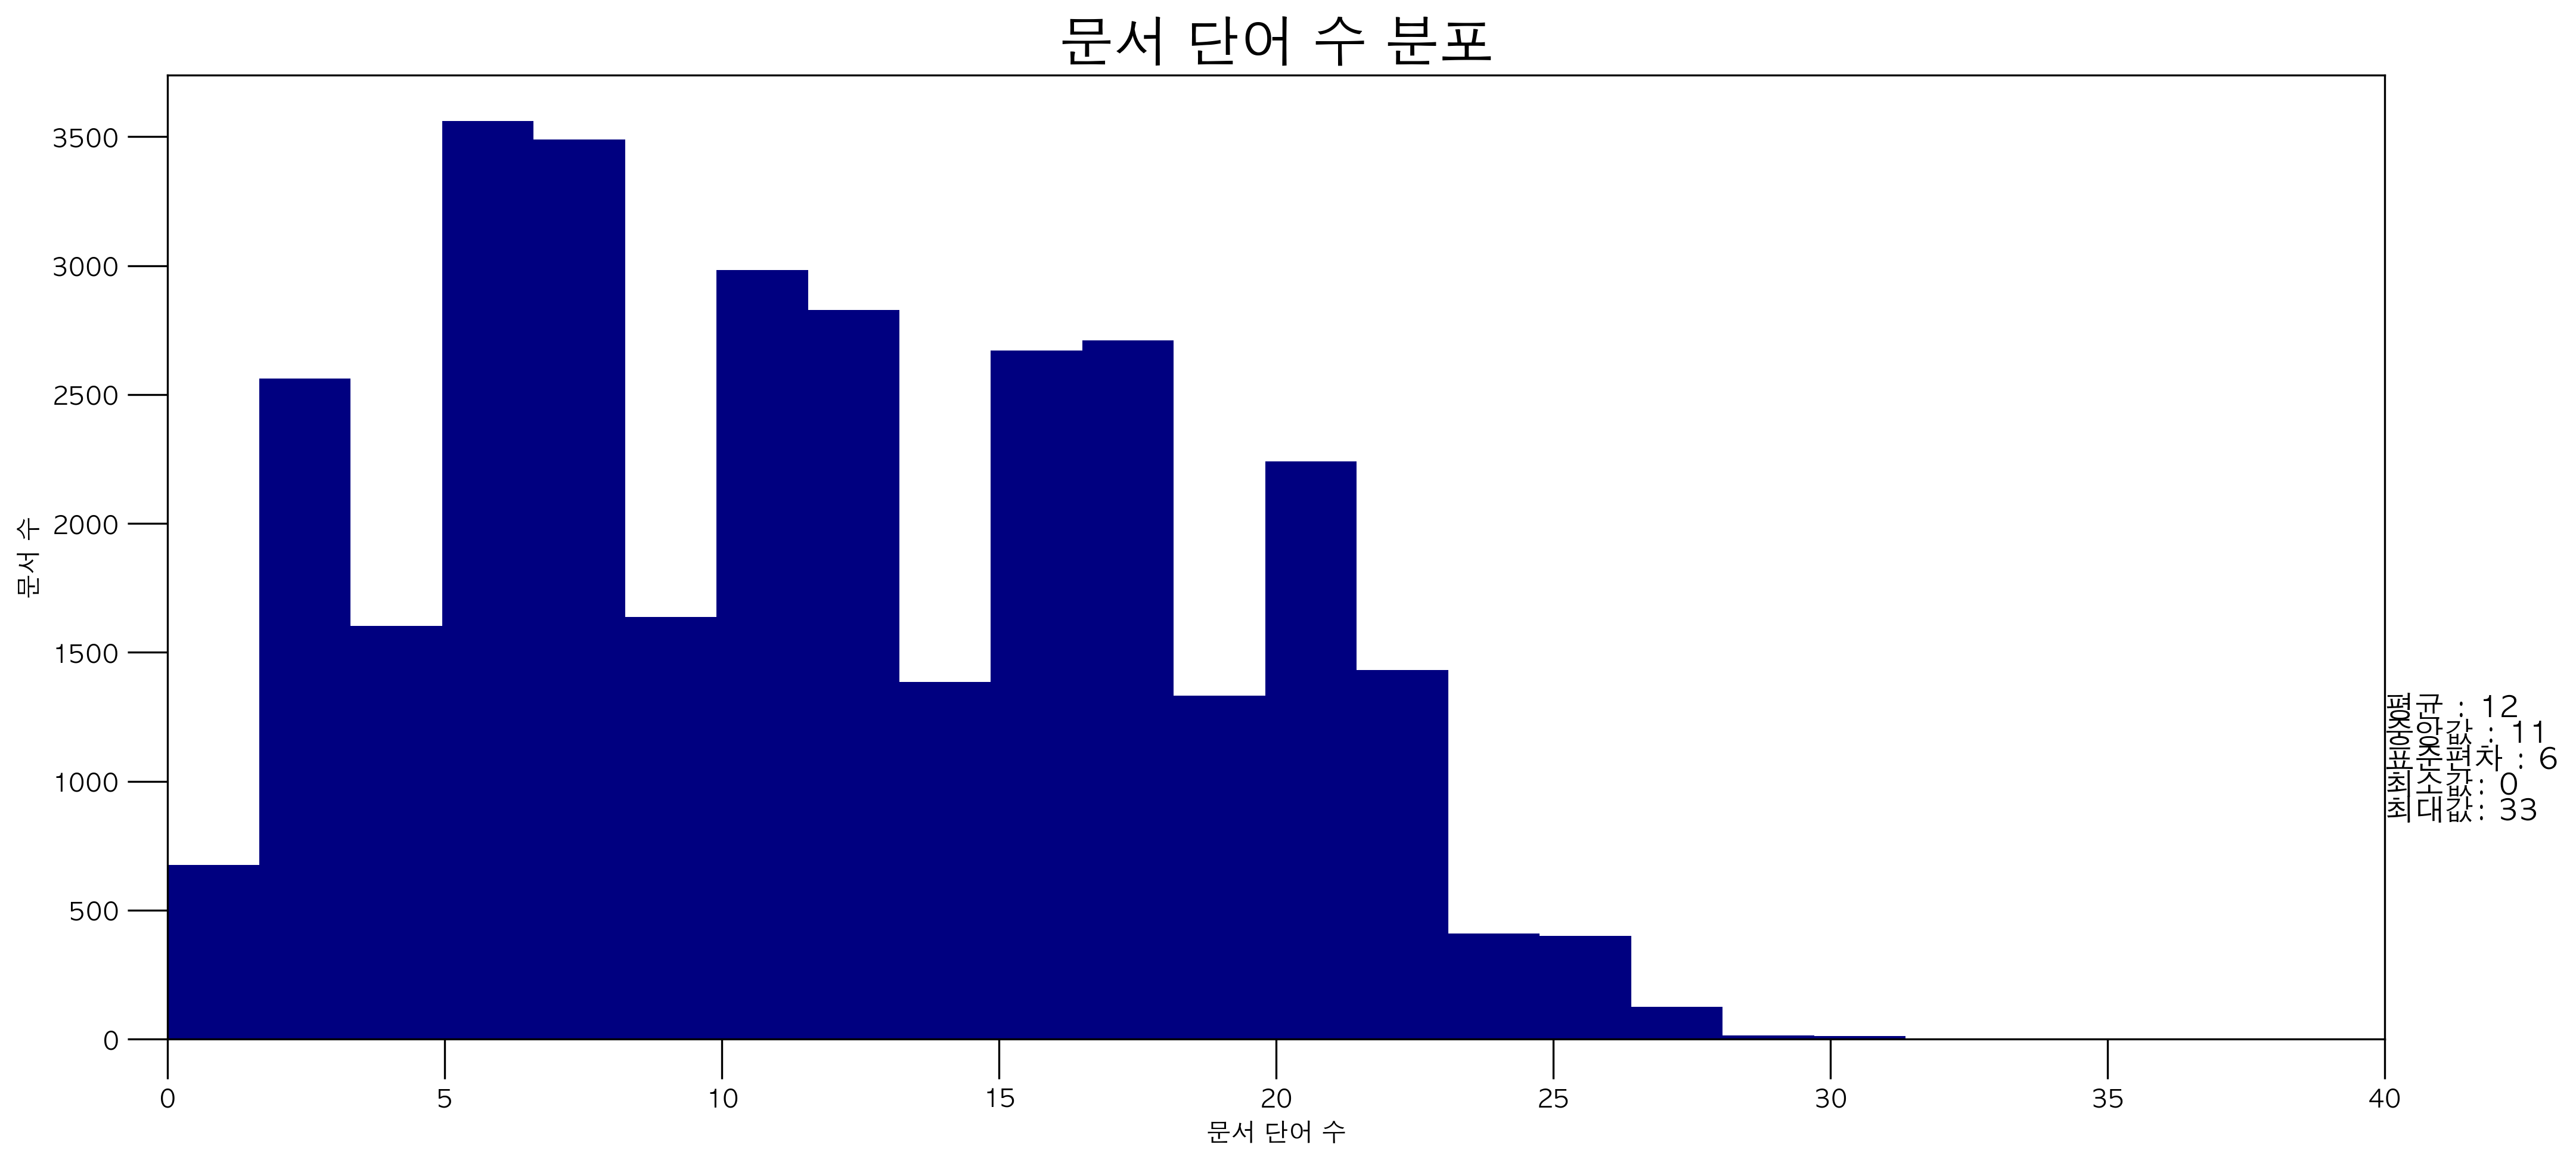

In [139]:
# 문서 길이 분포 시각화 함수
def plot_doc_length_distribution(df_dominant_topic, title):
    doc_lens = [len(d.split()) for d in df_dominant_topic]
    plt.figure(figsize=(16, 7), dpi=300)
    plt.hist(doc_lens, bins=20, color='navy')
    plt.text(40, 1250, "평균 : " + str(round(np.mean(doc_lens))), fontsize=12)
    plt.text(40, 1150, "중앙값 : " + str(round(np.median(doc_lens))), fontsize=12)
    plt.text(40, 1050, "표준편차 : " + str(round(np.std(doc_lens))), fontsize=12)
    plt.text(40, 950, "최소값: " + str(round(np.min(doc_lens))), fontsize=12)
    plt.text(40, 850, "최대값: " + str(round(np.max(doc_lens))), fontsize=12)
    plt.gca().set(xlim=(0, 40), ylabel='문서 수', xlabel='문서 단어 수')
    plt.tick_params(size=16)
    plt.title(title, fontdict=dict(size=22))
    plt.show()

plot_doc_length_distribution(df['cleaned_text'], '문서 단어 수 분포')

In [140]:
# N-그램 모델 처리
# 빅램(bigram)과 트라이그램(trigram) 모델을 생성하여 연속된 단어 조합을 학습
def process_ngram(data_words):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    data_words = [bigram_mod[doc] for doc in data_words]
    data_words = [trigram_mod[bigram_mod[doc]] for doc in data_words]
    
    return data_words

> 빅램 (2-그램): 최소 5번 이상 등장한 단어 조합이면서 연속된 단어의 점수가 100점을 초과하는 경우   
트라이그램 (3-그램): 빅램을 적용한 후에 트라이그램 학습을 진행, 높은 연결점수 (100점)을 가진 단어 조합만 트라이그램 학습 
  
  빅램과 트라이그램 모델로 학습한 내용을 data_words에 담아 분석에 사용.
 

---------  
**n-그램 모델을 적용하는 이유**
- 문맥적인 정보를 보존하기 위해 ("machine", "learning" -> machine_learning)  
- 자주 사용되는 단어 조합을 학습하여 모델 성능을 향상시키기 위해

In [141]:
# 문서를 단어 리스트로 변환
documents = [text.split() for text in df['cleaned_text']]

In [142]:
# 빅램과 트라이그램이 적용된 단어 리스트를 반환
documents = process_ngram(documents)

In [143]:
# 딕셔너리 크기 축소 함수
# Counter를 사용하여 전체 문서에서 특정 단어의 등장 횟수 체크
# 최소 등장 횟수 기준 이하의 단어를 딕셔너리에서 제거
def filter_dictionary_by_count(min_count, documents, dictionary):
    word_counter = Counter((word for words in documents for word in words))
    removal_word_idxs = {
        dictionary.token2id[word] for word, count in word_counter.items() if count < min_count
    }
    dictionary.filter_tokens(removal_word_idxs)
    dictionary.compactify()
    return dictionary

-> 빈도수가 너무 낮아 의미없는 단어들은 삭제함으로써 모델 학습을 최적화 하기 위함

In [144]:
# 빈 문서 제거
documents = [doc for doc in documents if isinstance(doc, list) and doc]

In [145]:
# Gensim 모델링을 위한 Dictionary 생성
dictionary = corpora.Dictionary(documents)

# 카운터 사용해서 딕셔너리 크기 축소
dictionary = filter_dictionary_by_count(3, documents, dictionary)

# dictionary 내 단어만 남긴 documents 필터링
filtered_documents = [[word for word in doc if word in dictionary.token2id] for doc in documents]

In [146]:
# 말뭉치 생성
corpus = [dictionary.doc2bow(text) for text in documents if text]
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


텍스트 데이터를 BOW(Bag of Words)형식으로 변환   

-----
**BOW(Bag of Words) : 텍스트를 숫자로 변환하는 방법**
1. 각 단어에 고유ID를 부여 
2. 각 문장에서 단어가 몇 번 나오는지를 센다.
3. 문장을 숫자의 조합으로 변환한다.   
  
ex) 1. 단어 목록 만들기 :    나는(0) 영어(1) 가(2) 재밌다(3)  
문장 1 ) 나는 영어가 재밌다 -> (0,1)(1,1)(2,1)(3,1) -> (1,1,1,1)  
문장 2 ) 나는 국어가 재밌다 -> (0,1)(1,0)(2,1)(3,1) -> (1,0,1,1)

# 토픽 모델링 (LDA)

LDA는 문서에서 숨겨진(잠재적인) 토픽을 찾아내는 기법으로, 문서가 어떤 토픽으로 이루어졌는지 해당 토픽은 어떤 단어들로 구성되어 있는지 확률적으로 분석하는 방식을 말한다. 

In [147]:
# LDA 모델을 학습 및 일관성 점수를 계산하여 최적의 토픽 수 서치하는 함수 정의
def compute_coherence_values(dictionary, corpus, texts, k_values, passes_list): 
    results = []
    for num_topics in k_values: 
        for passes in passes_list:
            # Train LDA model
            lda_model = gensim.models.LdaModel( corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42,passes=passes)
            # Compute coherence score 
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

            coherence_score = coherence_model.get_coherence() 
            results.append((num_topics, passes, coherence_score)) 
            print(f"Topics: {num_topics}, Passes: {passes}, Coherence:{coherence_score:.4f}") 
    return results

<**Coherence Score (일관성 점수)**>
토픽 모델이 얼마나 일관된 주제를 잘 찾았는지 평가하는 지표.  
일관성 점수가 높을수록 해당 토픽 모델이 더 적합함을 의미  

In [148]:
# 다양한 토픽 수와 패스를 설정해 LDA 모델 학습 시 사용
k_values = range(2, 6, 2)  # Number of topics (2, 4) 6,8 도 진행해봤으나 시간이 너무 오래 걸림
passes_list = [10, 20, 30]  # Passes (모델 학습 시 반복 횟수)

# LDA 모델을 학습하고 일관성 점수를 계산
results = compute_coherence_values(dictionary, corpus, documents, k_values, passes_list)

Topics: 2, Passes: 10, Coherence:0.3725
Topics: 2, Passes: 20, Coherence:0.3919
Topics: 2, Passes: 30, Coherence:0.3849
Topics: 4, Passes: 10, Coherence:0.3775
Topics: 4, Passes: 20, Coherence:0.3956
Topics: 4, Passes: 30, Coherence:0.3984


> Topics: 4, Passes: 10, Coherence:0.4258 이 가장 베스트로 나옴


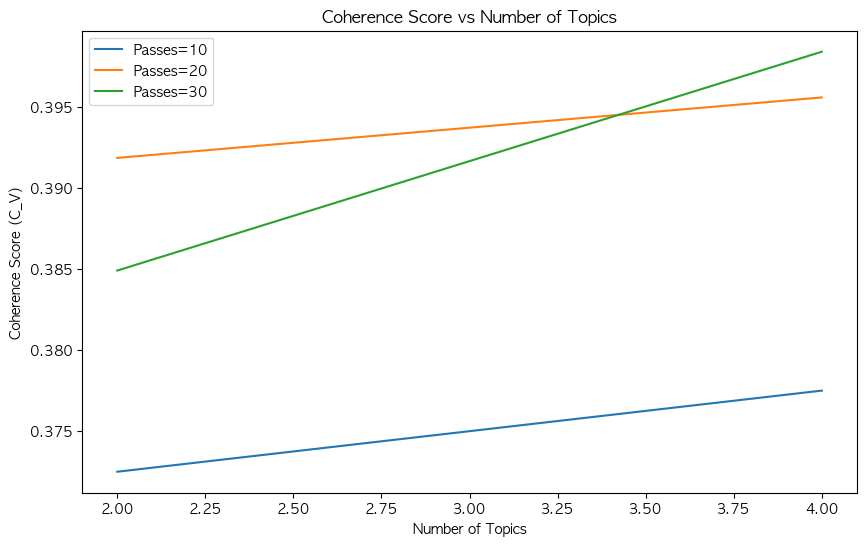

In [149]:
# 일관성 점수를 계산한 결과 시각화
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Coherence"])

plt.figure(figsize=(10, 6)) 
for passes in passes_list:
    subset = results_df[results_df["Passes"] == passes] 
    plt.plot(subset["Num_Topics"], subset["Coherence"], label=f'Passes={passes}')
plt.title('Coherence Score vs Number of Topics') 
plt.xlabel('Number of Topics') 
plt.ylabel('Coherence Score (C_V)')  
plt.legend()
plt.show()

In [150]:
# 최적의 토픽 수(4)와 패스(10)를 사용하여 LDA 모델 학습
# 일관성 점수가 가장 높은 조합 선택
optimal_num_topics, optimal_passes, _ = max(results, key=lambda x: x[2])
final_lda_model = gensim.models.LdaModel( corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, passes=optimal_passes, random_state=42)

for idx, topic in final_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.022*"model" + 0.014*"dialogue" + 0.012*"research" + 0.012*"help" + 0.011*"language_model" + 0.011*"free" + 0.010*"new" + 0.009*"data" + 0.008*"feedback" + 0.008*"system"
Topic 1: 0.027*"google" + 0.015*"new" + 0.013*"search" + 0.012*"make" + 0.012*"release" + 0.010*"launch" + 0.009*"future" + 0.009*"see" + 0.008*"today" + 0.008*"preview"
Topic 2: 0.018*"see" + 0.016*"pretty" + 0.014*"optimize" + 0.013*"good" + 0.012*"prompt" + 0.012*"much" + 0.011*"question" + 0.010*"give" + 0.010*"wow" + 0.009*"cool"
Topic 3: 0.027*"write" + 0.012*"think" + 0.010*"good" + 0.009*"know" + 0.009*"work" + 0.009*"make" + 0.009*"thing" + 0.008*"really" + 0.008*"answer" + 0.008*"people"


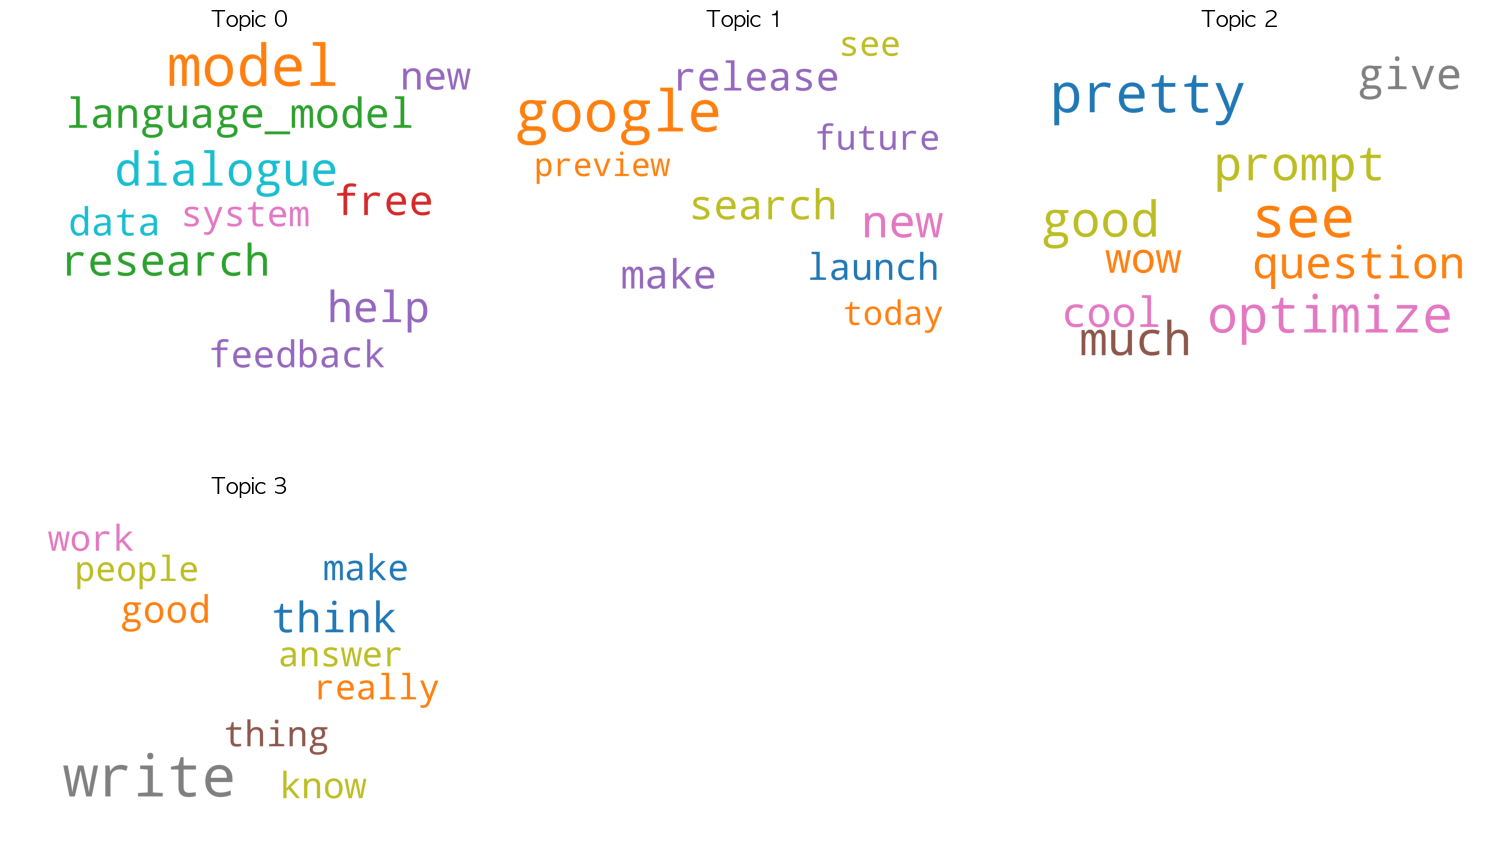

In [151]:
# 워드클라우드 생성
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=30, colormap='tab10', prefer_horizontal=1.0)

topics = final_lda_model.show_topics(formatted=False)
num_topics = len(topics)  # 실제 토픽 개수 확인

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(min(num_topics, len(axes))):  # 오류 방지: 실제 토픽 개수보다 많은 인덱스를 참조하지 않도록 조정
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    axes[i].imshow(cloud)
    axes[i].set_title(f'Topic {i}', fontdict=dict(size=16))
    axes[i].axis('off')

# 남은 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

> ### 불용어 핵심키워드 (openai, ai, chatgpt etc..) 등이 제거되지 않고 나타나는 문제 발생


**<토픽별 주요 단어의 중요도와 등장 횟수를 데이터프레임화 하여 확인>**

In [152]:
# 토픽 키워드의 단어 수
topics = final_lda_model.show_topics(formatted=False) 
data_flat = [w for w_list in documents for w in w_list] 
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
df2

,word,topic_id,importance,word_count
0,model,0,0.022017,699
1,dialogue,0,0.013722,73
2,research,0,0.011855,448
3,help,0,0.011643,1383
4,language_model,0,0.010824,216
5,free,0,0.010807,591
6,new,0,0.009556,2034
7,data,0,0.009285,583
8,feedback,0,0.008416,150
9,system,0,0.007981,438


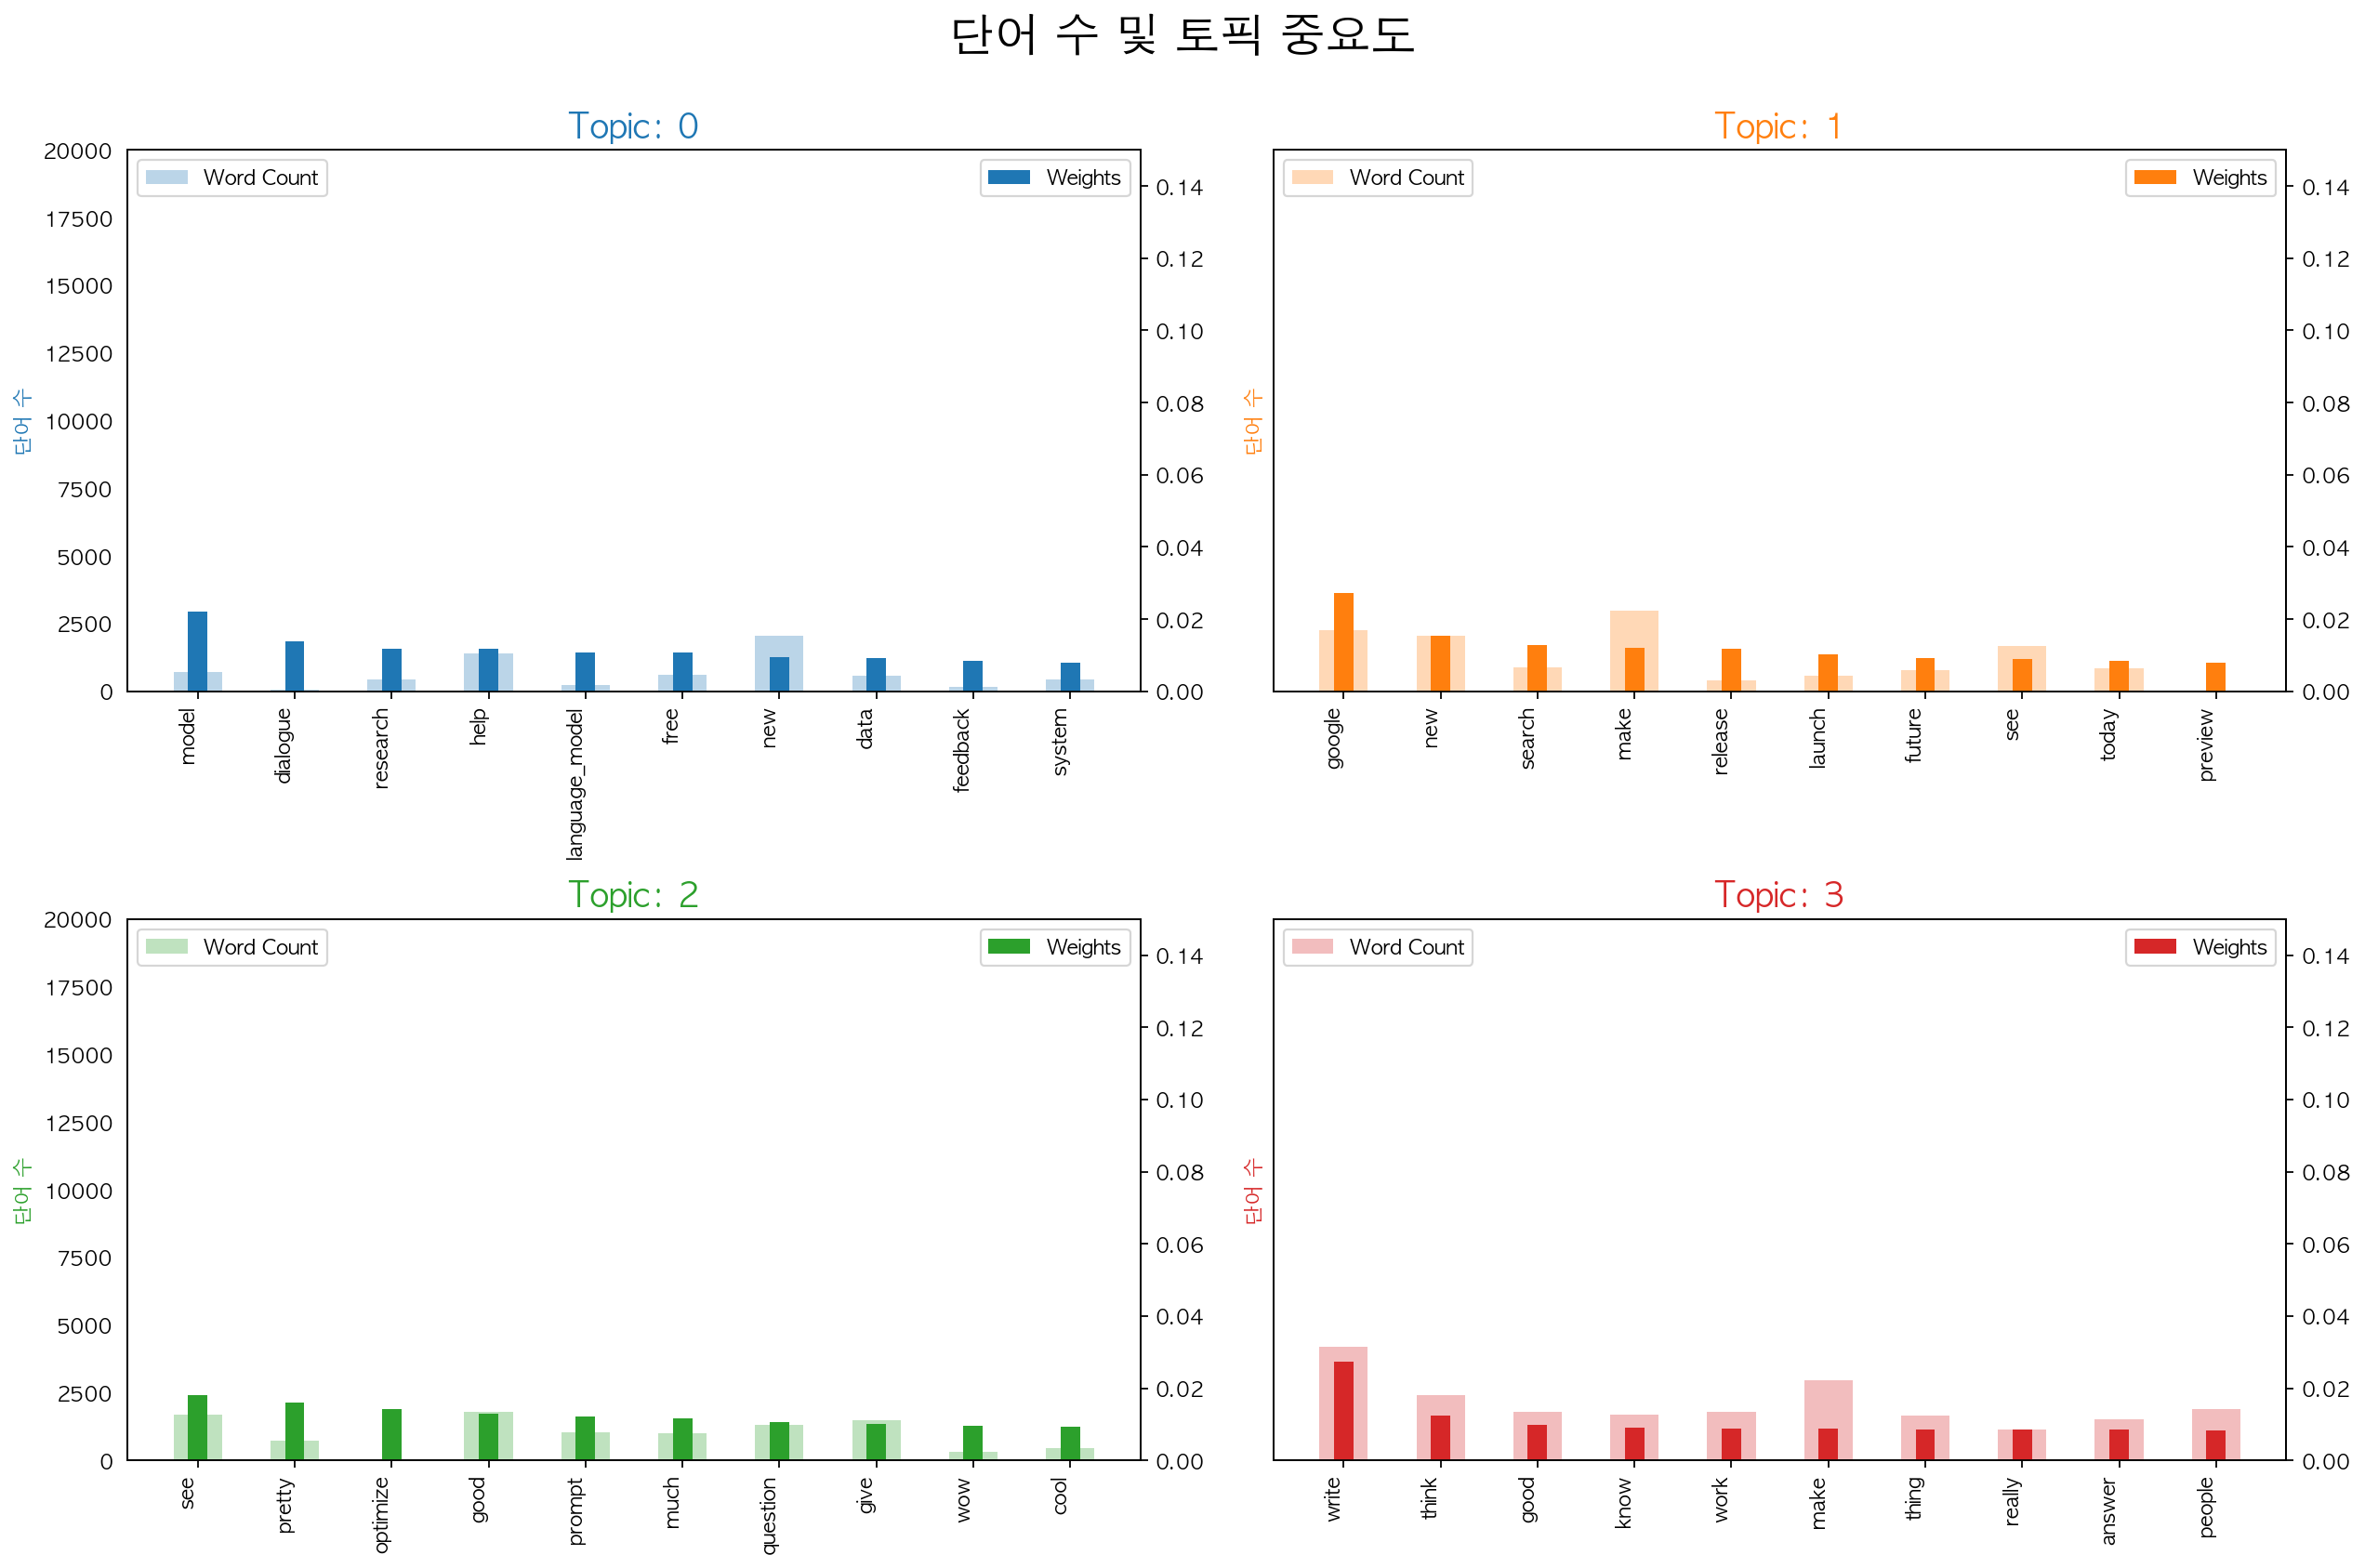

In [153]:
# 토픽의 단어 수와 Weights 시각화
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160) 
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()): 
    ax.bar(x='word', height="word_count", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx() 
    ax_twin.bar(x='word', height="importance", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('단어 수', color=cols[i]) 
    ax_twin.set_ylim(0, 0.15); 
    ax.set_ylim(0, 20000) 
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16) 
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=90, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('단어 수 및 토픽 중요도', fontsize=22, y=1.05)
plt.show()

___
시각화 해석

각 토픽에서 중요한 단어들의 단어 빈도수(Word Count)와 토픽 내 중요도(Weights)를 비교한 것  

1. Topic 0: ChatGPT의 사용 방법과 관련된 토론  (ask, write, use, prompt, question etc.)
2. Topic 1: ChatGPT에 대한 개인적인 경험과 감성  (try, get use, thing, see, im etc.)
3. Topic 2: ChatGPT의 교육적 활용 및 AI의 역할 (use, student, make, write, seem etc.)
4. Topic 3: ChatGPT의 기술 발전과 OpenAI의 새로운 발표   (new, google, release, future, model etc.)

In [154]:
# LDA 모델의 퍼플렉서티(Perplexity) 점수를 계산하기 위한 함수 정의
def compute_perplexity_values(dictionary, corpus, k_values, passes_list): 
    results = []
    for num_topics in k_values:  # 다양한 토픽 수를 사용하여 반복
        for passes in passes_list:  # 패스 수를 달리하여 반복
            # LDA 모델 학습
            lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=passes)
            # 퍼플렉서티 점수 계산
            perplexity_score = lda_model.log_perplexity(corpus) 
            results.append((num_topics, passes, perplexity_score)) 
            print(f"Topics: {num_topics}, Passes: {passes}, Perplexity: {perplexity_score:.4f}") 
    return results

In [155]:
# 토픽 수와 패스 범위
k_values = range(2, 6, 2)	# Number of topics
passes_list = [10, 20, 30]	# Passes

# 퍼플렉서티 점수를 계산
results = compute_perplexity_values(dictionary, corpus, k_values, passes_list)

Topics: 2, Passes: 10, Perplexity: -7.7756
Topics: 2, Passes: 20, Perplexity: -7.7491
Topics: 2, Passes: 30, Perplexity: -7.7340
Topics: 4, Passes: 10, Perplexity: -7.9005
Topics: 4, Passes: 20, Perplexity: -7.8714
Topics: 4, Passes: 30, Perplexity: -7.8559


퍼플렉서티(Perplexity): 언어 모델 예측 성능 평가 지표  
: 모델이 단어를 예측하는 데 얼마나 불확실한지를 측정  
값이 낮을수록 모델의 예측이 정확함을 의미.   

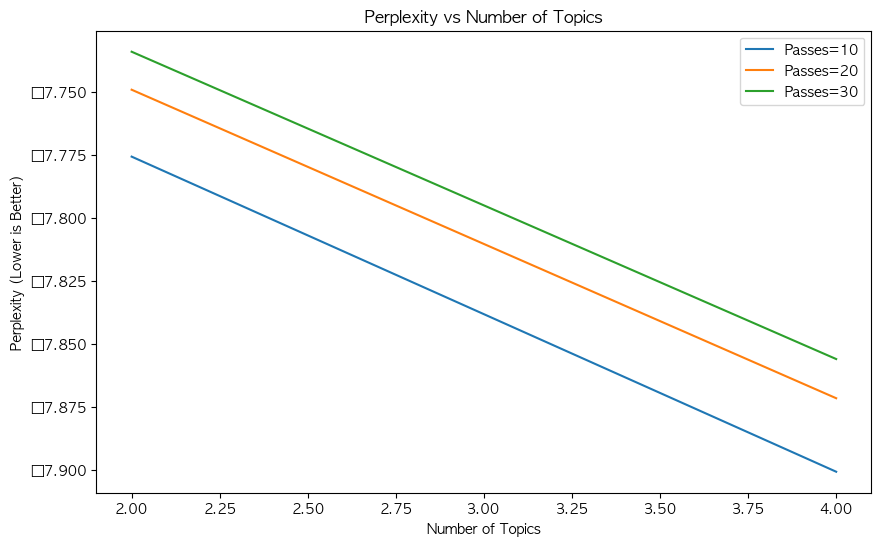

In [156]:
# 퍼플렉서티 점수 계산 결과 시각화
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Perplexity"])

plt.figure(figsize=(10, 6)) 
for passes in passes_list:
    subset = results_df[results_df["Passes"] == passes] 
    plt.plot(subset["Num_Topics"], subset["Perplexity"], label=f'Passes={passes}') 
plt.title('Perplexity vs Number of Topics') 
plt.xlabel('Number of Topics') 
plt.ylabel('Perplexity (Lower is Better)') 
plt.legend()
plt.show()

퍼플렉시티 지표로 확인해본 결과, 
일관성 점수 확인결과와 같은   
*Topics: 4, Passes: 10, Perplexity: -7.3978*  조합이 가장 베스트로 나옴. 

In [157]:
# 일관성 점수와 퍼플렉서티 점수를 결합하여 최적의 토픽 수를 찾는 함수 정의
def compute_combined_score(dictionary, corpus, texts, k_values, passes_list): 
    results = []
    coherence_scores = []
    perplexity_scores = []

    for num_topics in k_values:
        for passes in passes_list:
            # LDA 모델 학습
            lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=passes)
            # 일관성 점수 계산
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence = coherence_model.get_coherence()
            coherence_scores.append(coherence)

            # 퍼플렉서티 점수 계산
            perplexity = lda_model.log_perplexity(corpus)
            perplexity_scores.append(perplexity)
            results.append((num_topics, passes, coherence, perplexity))
            print(f"Topics: {num_topics}, Passes: {passes}, Coherence: {coherence:.4f}, Perplexity: {perplexity:.4f}")

    # 일관성 점수와 퍼플렉서티 점수를 정규화하여 결합 점수 계산
    coherence_array = np.array(coherence_scores).reshape(-1, 1)
    perplexity_array = np.array(perplexity_scores).reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_coherence = scaler.fit_transform(coherence_array).flatten()
    normalized_perplexity = scaler.fit_transform(-perplexity_array).flatten()

    # 결합 점수 계산 (일관성 점수와 퍼플렉서티 점수의 평균)
    combined_scores = 0.5 * normalized_coherence + 0.5 * normalized_perplexity
    for i, (num_topics, passes, coherence, perplexity) in enumerate(results):
        results[i] += (combined_scores[i],)  # 결합 점수 추가

    return results

In [158]:
# 토픽 수와 패스 범위 정의
k_values = range(2, 6, 2)
passes_list = [10, 20, 30]

# 결합 점수를 계산
results = compute_combined_score(dictionary, corpus, documents, k_values, passes_list)

Topics: 2, Passes: 10, Coherence: 0.3725, Perplexity: -7.7756
Topics: 2, Passes: 20, Coherence: 0.3919, Perplexity: -7.7491
Topics: 2, Passes: 30, Coherence: 0.3849, Perplexity: -7.7340
Topics: 4, Passes: 10, Coherence: 0.3775, Perplexity: -7.9005
Topics: 4, Passes: 20, Coherence: 0.3956, Perplexity: -7.8714
Topics: 4, Passes: 30, Coherence: 0.3984, Perplexity: -7.8559


In [159]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Coherence", "Perplexity", "Combined_Score"])

# 최적 매개변수 설정
topics_max_idx = results_df['Combined_Score'].idxmax()
optimal_params = results_df.loc[topics_max_idx]
print("Optimal Parameters:")
print(optimal_params)

Optimal Parameters:
Num_Topics         4.000000
Passes            30.000000
Coherence          0.398412
Perplexity        -7.855858
Combined_Score     0.865852
Name: 5, dtype: float64


> 일관성 점수와 퍼플렉서티 점수를 평균내서 계산하여 
단순히 퍼플렉서티가 가장 낮은 모델이 아니라 일관성과 퍼플렉서티의 균형이 좋은 모델을 선택

In [160]:
# 최적의 LDA 모델 생성
optimal_num_topics = optimal_params['Num_Topics']
optimal_passes = optimal_params['Passes']
final_lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=int(optimal_num_topics), passes=int(optimal_passes), random_state=42)

# LDA 모델 시각화
pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim.prepare(final_lda_model, corpus, dictionary)
pyLDAvis.display(lda_visualization)

원의 크기 :  해당 토픽이 해당 전체 문서에서 차지하는 중요도  
원 거리 : 토픽끼리의 유사도

# 감성 분석 및 예측 모델 생성

목표: 트윗 데이터를 기반으로 감성이 긍정인지 부정인지 예측하는 모델을 구축  
기존 데이터를 바탕으로 토픽 모델링이 잘 되었는가 확인

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [162]:
# 감성 레이블 정의
df = df[df['predicted_label'].notnull()]
df['label'] = df['predicted_label'].map({'negative': 0, 'positive': 1})

# 텍스트 데이터('cleaned_text')와 레이블('label'), 날짜('date')만 사용
df = df[['cleaned_text', 'label', 'date']]

# 데이터 불균형 확인
print("클래스 분포:")
print(df['label'].value_counts())

클래스 분포:
label
1    18574
0    13502
Name: count, dtype: int64


- predicted_label 칼럼의 결측치를 제외하고 negative:0으로 positive:1으로 매핑하여 label 칼럼 생성 
- 날짜, 텍스트내용 및 레이블 데이터를 바탕으로 분석

In [163]:
# 텍스트 데이터 벡터화 (TF-IDF 변환)
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(df['cleaned_text'])

-> 상위 5000개의 중요 단어만 사용하여 학습속도를 높이고 과적합 방지

---- 
TF-IDF(TermFrequency-InverseDocumentFrequency)
- 문서 내에서 특정 단어의 중요도를 구하는 작업
- 각 단어들마다 중요한 정도에 가중치를 매기는 방식
---- 

In [164]:
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['label'], test_size=0.2, random_state=42, stratify=df['label'])


# 랜덤포레스트

In [165]:
# 모델 학습 (랜덤 포레스트)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 예측 수행
y_pred = clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8276
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2701
           1       0.83      0.88      0.85      3715

    accuracy                           0.83      6416
   macro avg       0.83      0.82      0.82      6416
weighted avg       0.83      0.83      0.83      6416



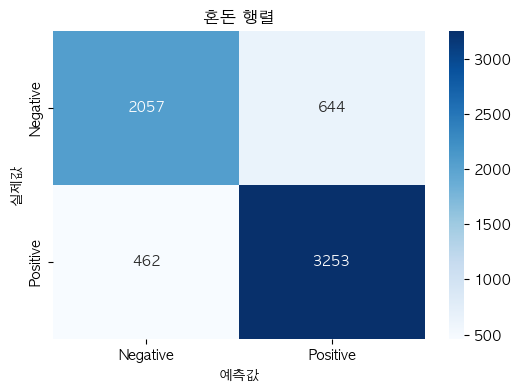

In [166]:
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('혼돈 행렬')
plt.show()

**랜덤포레스트 결과**  
690개의 부정 감성이 긍정으로 잘못 분류  
472개의 긍정 감성이 부정으로 잘못 분류  
- 전체적으로 모델의 성능은 높은 편이지만 부정 감성과 긍정 감성을 혼동하는 사례가 존재

In [167]:
# 가장 중요한 단어 출력 (TF-IDF 기준)
feature_names = vectorizer.get_feature_names_out()
feature_importances = np.mean(tfidf_features.toarray(), axis=0)

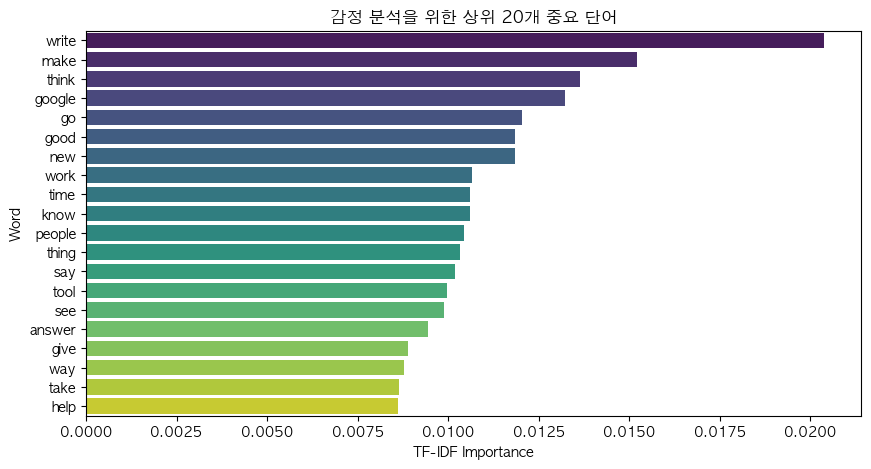

In [168]:
# 중요 단어 상위 20개 시각화
important_words = pd.DataFrame({'word': feature_names, 'importance': feature_importances})
important_words = important_words.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(10, 5))
sns.barplot(data=important_words, x='importance', y='word', palette='viridis')
plt.title('감정 분석을 위한 상위 20개 중요 단어')
plt.xlabel('TF-IDF Importance')
plt.ylabel('Word')
plt.show()

chatgpt, ai, use, write, get, ask 등이 주요 감성 관련 키워드  
new, work, time, people 등의 단어도 감성 분석에서 중요한 역할  
chatgpt와 ai 관련 언급이 많으며, write, ask 등의 단어가 감성 분석에 영향   
부정 감성은 problem, error 같은 단어와 연관될 가능성이 높음  
감성 예측 모델이 보다 정확한 감성 분류를 하도록 특정 단어의 가중치를 조정할 필요가 있어보임

In [169]:
# 감성 변화 분석 (시간에 따른 감성 변화 시각화)
df['date'] = df['date'].dt.date  # 날짜 단위로 변환하여 그룹화
sentiment_trend = df.groupby(['date', 'label']).size().unstack().fillna(0)

<Figure size 1200x600 with 0 Axes>

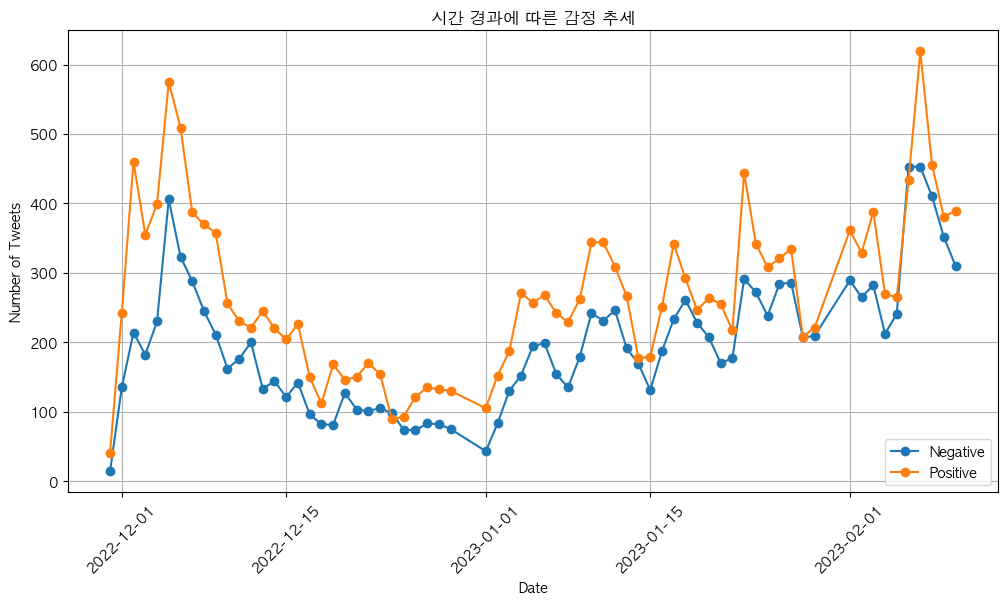

In [170]:
# 감성 변화 시각화
plt.figure(figsize=(12, 6))
sentiment_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('시간 경과에 따른 감정 추세')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(['Negative', 'Positive'])
plt.xticks(rotation=45)
plt.grid()
plt.show()

특정 시점에서 감성 변화(긍정/부정)를 추적하여 패턴을 분석    
12월 초 감성이 급격히 증가하며 부정 감성도 동반 상승  
1월 초 다시 감성 급변, 긍정 감성이 상대적으로 높음  
2월 초 감성 변동이 심하며 새로운 이슈가 발생했을 가능성  

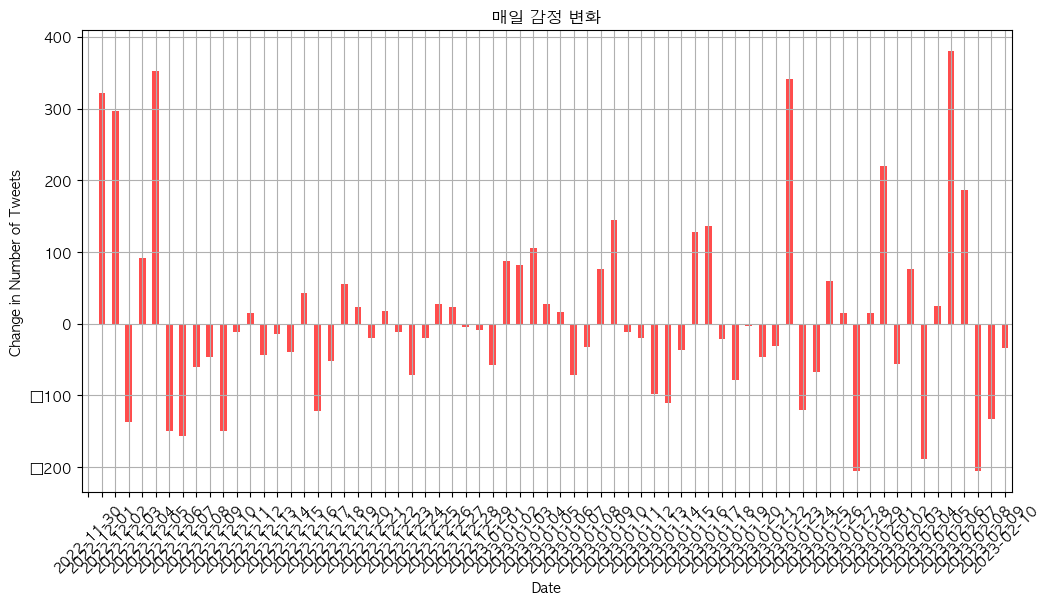

In [171]:
# 특정 시점에서 감성이 급격히 변하는지 탐색
sentiment_trend['change'] = sentiment_trend.sum(axis=1).diff()
plt.figure(figsize=(12, 6))
sentiment_trend['change'].plot(kind='bar', color='red', alpha=0.7)
plt.title('매일 감정 변화')
plt.xlabel('Date')
plt.ylabel('Change in Number of Tweets')
plt.xticks(rotation=45)
plt.grid()
plt.show()


y > 0 : 해당 일자에 긍정 감성이 증가했음  
y < 0 : 해당 일자에 부정 감성이 증가했음  
일일 감성 변화 그래프를 통해 어떤 이슈가 부정/ 긍정 감성으로의 급격한 변화를 일으켰는지 파악할 수 있다. 

# SVC

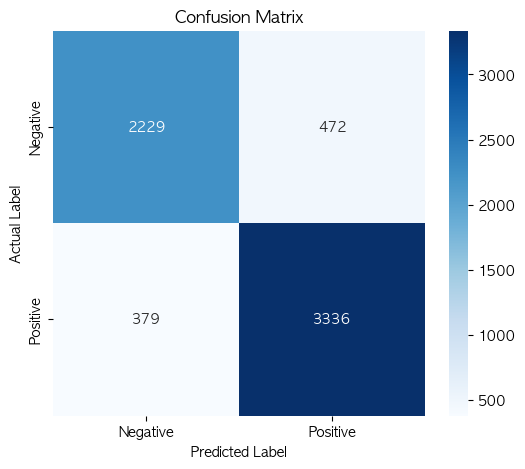

Accuracy Score:
0.8673628428927681
 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2701
           1       0.88      0.90      0.89      3715

    accuracy                           0.87      6416
   macro avg       0.87      0.86      0.86      6416
weighted avg       0.87      0.87      0.87      6416



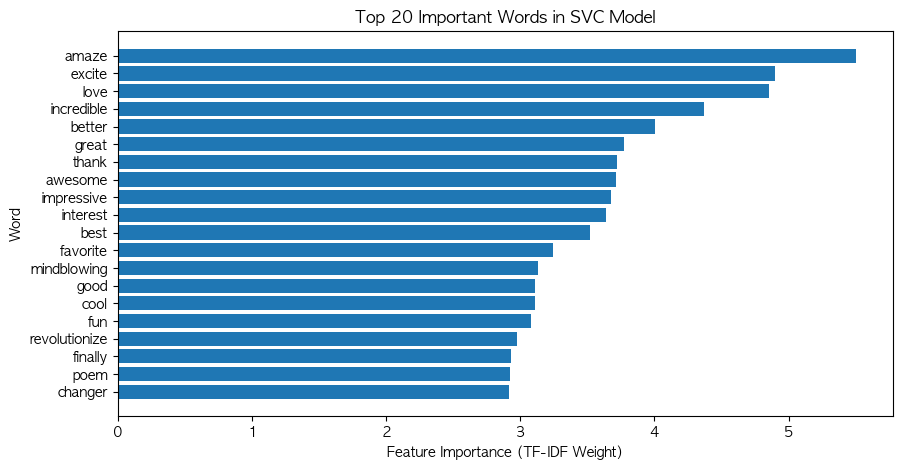

In [172]:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import itertools

svc_model = SVC(kernel='linear', probability=True)  # 선형 SVM 사용
svc_model.fit(X_train, y_train)

# 예측
y_pred = svc_model.predict(X_test)

# 혼동 행렬(Confusion Matrix) 시각화
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# 혼동행렬 계산
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

# 분석 보고서 출력 
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print(" Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance (TF-IDF 가중치가 높은 단어 상위 20개 시각화)
def plot_feature_importance(model, vectorizer, top_n=20):
    coef = model.coef_.toarray().flatten()  
    feature_names = vectorizer.get_feature_names_out()

    # 중요도가 높은 단어 상위 20개 선택
    top_features = np.argsort(coef)[-top_n:]

    plt.figure(figsize=(10, 5))
    plt.barh(range(top_n), coef[top_features], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in top_features])
    plt.xlabel("Feature Importance (TF-IDF Weight)")
    plt.ylabel("Word")
    plt.title("Top 20 Important Words in SVC Model")
    plt.show()

plot_feature_importance(svc_model, vectorizer)



**SVC 결과**  
- 459개의 부정 감성이 긍정으로 잘못 분류   (rf:690)  
- 369개의 긍정 감성이 부정으로 잘못 분류   (rf:472)  
-> 랜덤포레스트에 비해 확실히 더 잘 분류하고 있음을 알 수 있음 

- amaze, excite, love, incnredible, great, awesome 등의 단어가 svc분석에 중요하게 사용됨.

# 예측 모델 최종 결과

가장 최적의 모델 : **SVC**  
- accuracy: 0.8709  
            ______ precision     recall  f1-score    
negatvie 0.86  0.83  0.84  
positive  0.88 0.90  0.89  

-> 위 속성 중요도 분석에서 긍정적 단어가 중요하게 여겨진 것으로 보아 SVC 모델은 긍정 감성을 좀 더 정확하게 예측하고 있다.

----

1. stopwords로 chatgpt등을 제외하는 코드를 사용했는데도 사라지지 않고 계속 나타남. 이 부분을 해결하지 못했음.
2. neutral 칼럼을 제외하고 모델링을 돌려봤으나 오히려 포함시키고 돌린 모델링이 조금씩 정확도가 높았음. 
